In [11]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Timer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import wandb
from torch.utils.data import DataLoader
import gc
from model import AE_MLP
import json




In [12]:
from datetime import datetime

In [32]:

class custom_args():
    def __init__(self):
        self.FULLTRAIN = False
        self.TEST = False
        self.usegpu = True
        self.purgedCV = True
        self.gpuid = 0
        self.seed = 42
        self.model = 'AE_MLP'
        self.use_wandb = False
        self.use_tb = True
        self.project = 'AE_MLP-purgedcv-with-lags-test'
        self.save_model_root = f"{self.project}"
        os.makedirs(self.save_model_root, exist_ok=True) 
        self.dname = "./input_df/"
        self.tbroot = "/tf-logs"
        self.loader_workers = 6

        self.weight_decay = 5e-4
        self.dropouts = [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882, 0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448]
        #self.dropouts = [0.035, 0.035, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
        if self.TEST:
            self.bs = 8192  
            self.lr =   1e-3
            self.n_hidden = [96, 96, 896, 448, 448, 256]
            self.patience = 5
            self.max_epochs = 1
            self.N_fold = 2
        else:
            self.bs = 4 * 8192
            self.lr = 1e-3
            self.n_hidden = [96, 96, 896, 448, 448, 256]
            self.patience = 15
            self.max_epochs = 2000
            self.N_fold = 5
        self.input_path = './'
        self.train_path = f"{self.input_path}/training_data.parquet"
        self.valid_path = f"{self.input_path}/validation_data.parquet"
        
        # self.feature_names = [f"feature_{i:02d}" for i in range(79)] + [f"responder_{idx}_lag_1" for idx in range(9)]
        self.feature_names = ['weekday',
        'is_month_end',
        'Year',
        'Month',
        'Day',
        'DayOfWeek',
        'Lag_in_1',
        'Lag_in_2',
        'Lag_in_3',
        'Lag_in_4',
        'Lag_in_5',
        'Lag_in_6',
        'Lag_in_7',
        'Lag_in_8',
        'Lag_in_9',
        'Lag_in_10',
        'Lag_in_11',
        'Lag_in_12',
        'Lag_in_13',
        'Lag_in_14',
        'Lag_in_15',
        'Lag_in_16',
        'Lag_in_17',
        'Lag_in_18',
        'Lag_in_19',
        'Lag_in_20',
        'Lag_in_21',
        'Lag_in_22',
        'Lag_in_23',
        'Lag_in_24',
        'Lag_in_25',
        'Lag_in_26',
        'Lag_in_27',
        'Lag_in_28',
        'Lag_in_29',
        'Lag_out_1',
        'Lag_out_2',
        'Lag_out_3',
        'Lag_out_4',
        'Lag_out_5',
        'Lag_out_6',
        'Lag_out_7',
        'Lag_out_8',
        'Lag_out_9',
        'Lag_out_10',
        'Lag_out_11',
        'Lag_out_12',
        'Lag_out_13',
        'Lag_out_14',
        'Lag_out_15',
        'Lag_out_16',
        'Lag_out_17',
        'Lag_out_18',
        'Lag_out_19',
        'Lag_out_20',
        'Lag_out_21',
        'Lag_out_22',
        'Lag_out_23',
        'Lag_out_24',
        'Lag_out_25',
        'Lag_out_26',
        'Lag_out_27',
        'Lag_out_28',
        'Lag_out_29',
        'Rolling_Mean_out']

        self.label_name = 'in'
        self.weight_name = 'weight'
        
        self.test_train_ratio = 5
        self.time_col = "date_id"  
        self.group_gap = 31

args = custom_args()

In [30]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import (LightningDataModule, LightningModule)
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from matplotlib import pyplot as plt
import gc
os.environ["POLARS_MAX_THREADS"] = "4"
import polars as pol

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose
        
    def split(self, X, y=None, groups=None):
        
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            #train_array = []
            #test_array = []
            train_indices = set()  # 使用集合代替列表
            test_indices = set()   # 使用集合代替列表
            
            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                #train_array_tmp = group_dict[train_group_idx]
                #train_array = np.sort(np.unique(np.concatenate((train_array,train_array_tmp)),axis=None), axis=None)
            #train_end = train_array.size
                train_indices.update(group_dict[train_group_idx])  # 使用 update 添加数据并自动去重
 
            
            
            for test_group_idx in unique_groups[group_test_start:group_test_start +group_test_size]:
                #test_array_tmp = group_dict[test_group_idx]
                #test_array = np.sort(np.unique(np.concatenate((test_array,test_array_tmp)),axis=None), axis=None)
            #test_array  = test_array[group_gap:]
                test_indices.update(group_dict[test_group_idx])  # 使用 update 添加数据并自动去重
            
            #Optionally remove the group_gap from the test indices
            #if self.group_gap:
                #test_indices.difference_update(set(range(max(train_indices) + 1, max(train_indices) + 1 + self.group_gap)))
            
            if self.verbose > 0:
                    pass
                    
            #yield [int(i) for i in train_array], [int(i) for i in test_array]
            yield sorted(train_indices), sorted(test_indices) 


class CustomDataset(Dataset):
    def __init__(self, df,   accelerator):
        self.features = torch.FloatTensor(df[args.feature_names].values).to(accelerator)
        self.labels = torch.FloatTensor(df[args.label_name].values).to(accelerator)
        self.weights = torch.FloatTensor(df[args.weight_name].values).to(accelerator)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        w = self.weights[idx]
        return x, y, w


class DataModule(LightningDataModule):
    def __init__(self, train_path, valid_path, batch_size, valid_df=None, time_col = "date_id", accelerator='cpu', TEST = False):
        super().__init__()
        self.train_path = train_path
        self.valid_path = valid_path
        self.dates = pol.scan_parquet(train_path).select(time_col).unique().collect().to_numpy().squeeze(-1).tolist()
        self.batch_size = batch_size
        self.accelerator = accelerator
        self.train_dataset = None
        self.val_dataset = None
        self.TEST = TEST
        

    def setup(self,  train_selected_dates = None, valid_selected_dates = None, time_col = "date_id"):
        
        train = pol.scan_parquet(self.train_path).fill_null(strategy="forward").fill_null(0)
        valid = pol.scan_parquet(self.valid_path).fill_null(strategy="forward").fill_null(0)
        #train = pol.scan_parquet(f"{input_path}/training_data.parquet")
        #valid = pol.scan_parquet(f"{input_path}/validation_data.parquet")

        if train_selected_dates:
            train = train.filter(pol.col(time_col).is_in(train_selected_dates))
        if valid_selected_dates:
            valid = valid.filter(pol.col(time_col).is_in(valid_selected_dates))

        if self.TEST:
            train = train.head(1000000)
            valid = valid.head(100000)

        
        train = train.collect().to_pandas()
        valid = valid.collect().to_pandas()

        
        print(train.shape, valid.shape )

        self.train_dataset = CustomDataset(train, self.accelerator)
    
        self.val_dataset = CustomDataset(valid, self.accelerator)
        
        gc.collect()


    def get_purged_cv_and_plot(self, N_fold, test_train_ratio, group_gap , time_col, save_figure=True):
        """
        根据给定的时间列，生成PurgedGroupTimeSeriesSplit的CV划分并绘制图表。
        
        Args:
         N_fold, test_train_ratio, group_gap ,
            time_col: 时间列的名称。
            save_figure: 是否保存图表。
        """
        # 根据测试模式选择数据集
        if self.TEST:
            train = (
                pol.scan_parquet(self.train_path)
                .fill_null(strategy="forward")
                .fill_null(0)
                .filter(pol.col(time_col) >= 1500)
                .collect()
            )
        else:
            train = (
                pol.scan_parquet(self.train_path)
                .fill_null(strategy="forward")
                .fill_null(0)
                .collect()
            )
        
        # 数据处理
        train = train.sort(time_col).to_pandas()
        len_timeids = len(train[time_col].unique())
        print(f"总共天数: {len_timeids}")
        
        # 计算划分参数
        max_test_group_size = int(len_timeids / (N_fold + test_train_ratio))
        max_train_group_size = max_test_group_size * test_train_ratio
        print(f"max_test_group_size: {max_test_group_size}")
        print(f"max_train_group_size: {max_train_group_size}")
        print(f"group_gap: {group_gap}")
        
        # 创建CV划分对象
        cv = PurgedGroupTimeSeriesSplit(
            n_splits=N_fold,
            max_train_group_size=max_train_group_size,
            group_gap=group_gap,
            max_test_group_size=max_test_group_size,
        )
        
        # 生成和可视化CV划分
        splits = cv.split(train, groups=train[time_col].to_numpy())
        plt.figure(figsize=(24, 8))
        dates_each_fold = []
        
        for i, (train_idx, test_idx) in enumerate(splits):
            print(f"Processing fold {i}")
            
            # 获取训练和测试时间范围
            train_start_date = train[time_col][train_idx[0]]
            train_end_date = train[time_col][train_idx[-1]]
            test_start_date = train[time_col][test_idx[0]]
            test_end_date = train[time_col][test_idx[-1]]
            
            # 记录日期范围
            train_dates = range(train_start_date, train_end_date + 1)
            test_dates = range(test_start_date, test_end_date + 1)
            dates_each_fold.append((train_dates, test_dates))
            
            # 打印范围信息
            print(f"fold {i} train: {train_start_date} - {train_end_date}")
            print(f"fold {i} test: {test_start_date} - {test_end_date}")
            
            # 绘制训练数据
            plt.plot([train_start_date, train_end_date], [i, i], marker='o', color='blue')
            plt.text(train_start_date, i + 0.1, f"{train_start_date}", ha='right')
            plt.text(train_end_date, i + 0.1, f"{train_end_date}", ha='right')
            
            # 绘制测试数据
            plt.plot([test_start_date, test_end_date], [i, i], marker='o', color='red')
            plt.text(test_start_date, i - 0.2, f"{test_start_date}", ha='right')
            plt.text(test_end_date, i - 0.2, f"{test_end_date}", ha='right')
        
        # 清理资源
        del train
        gc.collect()
        
        # 图表设置与保存
        plt.title('Purged_Group_TimeSeries_Split')
        plt.xlabel('Time_Col')
        plt.ylabel('CV_Iteration')
        if save_figure:
            plt.savefig('./cv_plan.png')

        return dates_each_fold

    def setup_purged_cv(self, train_selected_dates, valid_selected_dates, time_col):
        
        df = pol.scan_parquet(self.train_path).fill_null(strategy="forward").fill_null(0)
        
        train = df.filter(pol.col(time_col).is_in(train_selected_dates))
        valid = df.filter(pol.col(time_col).is_in(valid_selected_dates))
            
            
        train = train.collect().to_pandas()
        valid = valid.collect().to_pandas()
        
        print(train.shape, valid.shape)

        self.train_dataset = CustomDataset(train, self.accelerator)

        self.val_dataset = CustomDataset(valid, self.accelerator)

        
        gc.collect()


    def train_dataloader(self, n_workers=0):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=n_workers)#, pin_memory=True, persistent_workers=True)#

    def val_dataloader(self, n_workers=0):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=n_workers)#, persistent_workers=True)#, pin_memory=True)

总共天数: 488
max_test_group_size: 48
max_train_group_size: 240
group_gap: 31
Processing fold 0
fold 0 train: 0 - 216
fold 0 test: 248 - 295
Processing fold 1
fold 1 train: 25 - 264
fold 1 test: 296 - 343
Processing fold 2
fold 2 train: 73 - 312
fold 2 test: 344 - 391
Processing fold 3
fold 3 train: 121 - 360
fold 3 test: 392 - 439
Processing fold 4
fold 4 train: 169 - 408
fold 4 test: 440 - 487


Seed set to 42


setup date for fold 0
fold 0 train: 0 - 216
fold 0 test: 248 - 295
(217, 73) (48, 73)
success setup fold 0
devices: [0], accelerator: cpu


TypeError: `devices` selected with `CPUAccelerator` should be an int > 0.

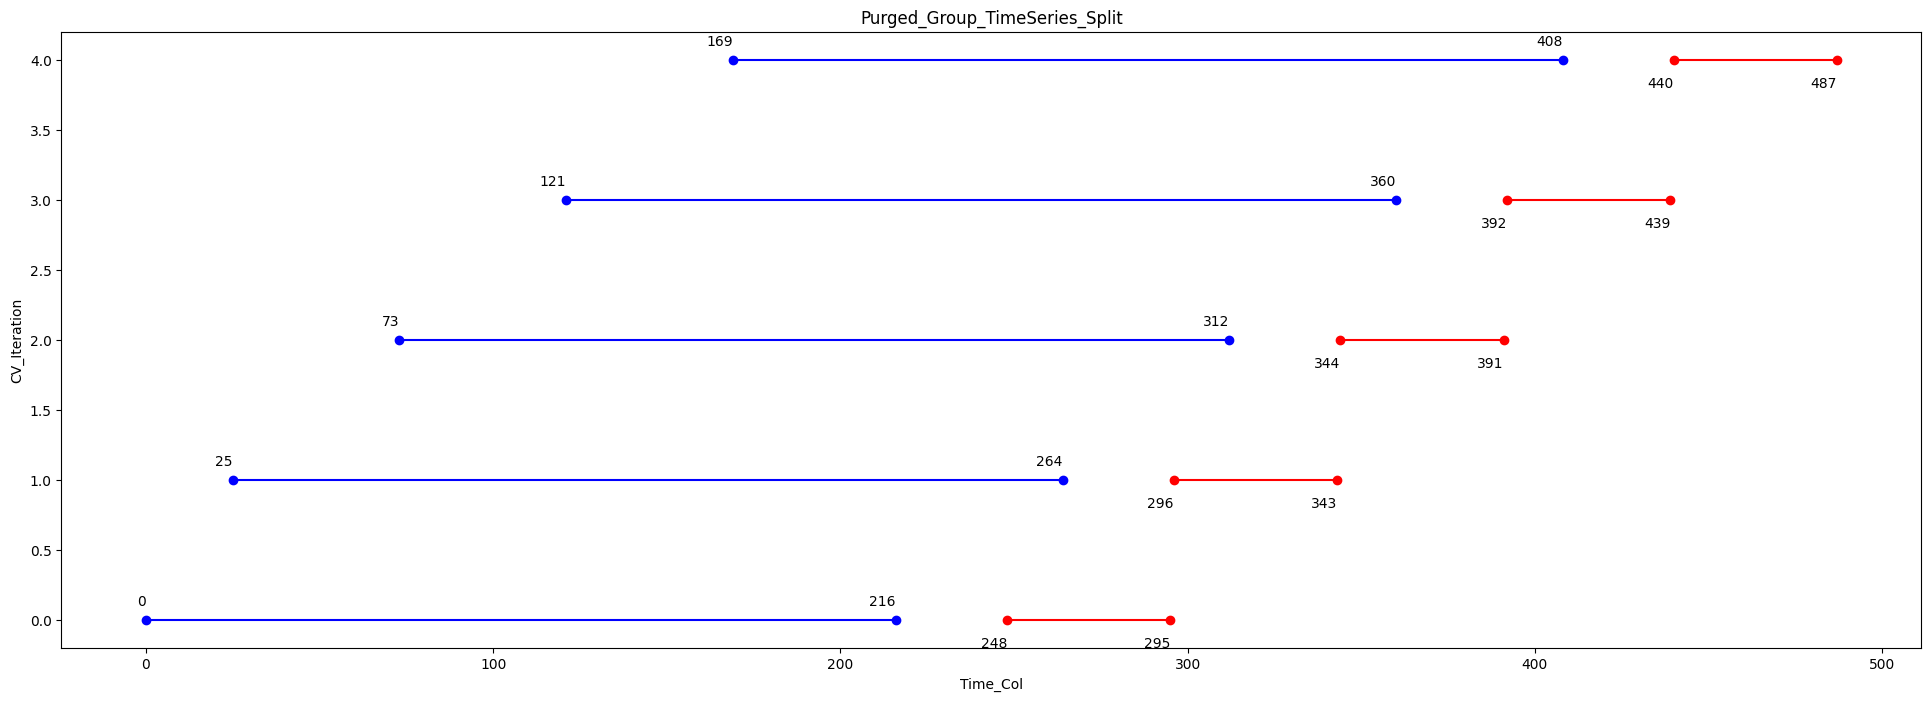

In [34]:



# 检查设备
device = torch.device(f'cuda:{args.gpuid}' if torch.cuda.is_available() and args.usegpu else 'cpu')
accelerator = 'gpu' if torch.cuda.is_available() and args.usegpu else 'cpu'
loader_device = 'cpu'

if args.FULLTRAIN:
    data_module = DataModule([args.train_path , args.valid_path ], args.valid_path, batch_size=args.bs, accelerator=loader_device, TEST = args.TEST)
else:
    data_module = DataModule(args.train_path, args.valid_path, batch_size=args.bs, accelerator=loader_device, TEST = args.TEST)

dates_each_fold = data_module.get_purged_cv_and_plot(args.N_fold, args.test_train_ratio, args.group_gap , args.time_col )

# 设置全局随机种子
pl.seed_everything(args.seed)

saved_epochs = {}

for fold, (train_dates, valid_dates) in enumerate(dates_each_fold):
    print(f"setup date for fold {fold}")
    print(f"fold {fold} train: {train_dates[0]} - {train_dates[-1]}")
    print(f"fold {fold} test: {valid_dates[0]} - {valid_dates[-1]}")
    data_module.setup_purged_cv(train_dates, valid_dates, args.time_col)
    
    print(f"success setup fold {fold}")

    # 获取输入维度
    input_dim = data_module.train_dataset.features.shape[1]

    # 初始化模型
    model = AE_MLP(
        num_columns=input_dim,
        num_labels=1,
        hidden_units=args.n_hidden,
        dropout_rates=args.dropouts,
        lr=args.lr,
        weight_decay=args.weight_decay
    )

    # 初始化日志记录器
    if args.use_wandb:
        wandb_run = wandb.init(project=args.project, config=vars(args), reinit=True)
        logger = WandbLogger(experiment=wandb_run)
    elif args.use_tb:
        logger = TensorBoardLogger(args.tbroot, name=f"{args.project}_fold_{fold}")
    else:
        logger = None

    # 初始化回调函数
    early_stopping = EarlyStopping('val_r_square', patience=args.patience, mode='max', verbose=False)
    checkpoint_callback = ModelCheckpoint(monitor='val_r_square', mode='max', save_top_k=1, verbose=True, filename=os.path.join(args.save_model_root, f"nn_{fold}.model"))
    timer = Timer()
    
    devices=[args.gpuid] if args.usegpu else 1
    print(f"devices: {devices}, accelerator: {accelerator}")

    # 初始化Trainer
    trainer = Trainer(
        max_epochs=args.max_epochs,
        accelerator=accelerator,
        devices=devices,
        logger=logger,
        callbacks=[early_stopping, checkpoint_callback, timer],
        enable_progress_bar=True,
    )

    # 开始训练
    trainer.fit(model, data_module.train_dataloader(args.loader_workers), data_module.val_dataloader(args.loader_workers))
    
    saved_epochs[fold] = model.train_epoch_record
    print(f"Fold-{fold} Training completed in {timer.time_elapsed('train'):.2f}s")

# 保存 saved_epochs 到 JSON 文件
with open(os.path.join(args.save_model_root, f"saved_epochs.json") , "w") as f:
    json.dump(saved_epochs, f, indent=4)
print("Saved epochs information to 'saved_epochs.json'")

In [5]:
model.train_epoch_record

[{'epoch': 0,
  'val_r_square': -6.389523029327393,
  'val_loss': 11.830615043640137}]

In [ ]:
    saved_epochs[fold] = {
        'best_score': float(best_epoch) if best_epoch is not None else None,
        'best_epoch': best_epoch_index
    }

    print(f"Fold-{fold} Training completed in {timer.time_elapsed('train'):.2f}s")
    print(f"Best model saved for fold {fold} at epoch {best_epoch_index} with score {best_epoch}")



In [ ]:
# 最后用最后一个fold最好的epoch训练一个日期最新的模型，模型训练集长度和之前一样
# 打印所有保存的epoch信息
print("Saved model epochs information:")
for fold, info in saved_epochs.items():
    print(f"Fold {fold}: Best Epoch = {info['best_epoch']}, Best Score = {info['best_score']}")

# 保存 saved_epochs 到 JSON 文件
with open(os.path.join(args.save_model_root, f"saved_epochs.json") , "w") as f:
    json.dump(saved_epochs, f, indent=4)
print("Saved epochs information to 'saved_epochs.json'")